In [6]:
import networkx as nx
import numpy as np

# Define the edges from the provided notation
edges = [
    (0, 4, 11),
    (1, 4, 2),
    (2, 5, 6),
    (3, 5, 7),
    (4, 0, 11),
    (4, 1, 2),
    (4, 5, 4),
    (5, 4, 4),
    (5, 3, 7),
    (5, 2, 6),
]

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
for a, b, c in edges:
    G.add_edge(a, b, weight=c)

def create_matrix(N, G):
    matrix_distance = np.zeros((N, N), dtype=int)  # Initialize the matrix with zeros

    for i in range(N):
        for j in range(N):
            if i == j:
                matrix_distance[i][j] = 0  # Distance from a node to itself is 0
            else:
                try:
                    # Use Dijkstra's algorithm to find the shortest path from node i to j
                    matrix_distance[i][j] = nx.dijkstra_path_length(G, i, j, weight='weight')
                except nx.NetworkXNoPath:
                    matrix_distance[i][j] = float('inf')  # If no path exists, set to infinity

    return matrix_distance

# Call the function to create the distance matrix
N = 4
matrix = create_matrix(N, G)

# Print matrix in the desired format
for row in matrix:
    print('\t'.join(map(str, row)))


0	13	21	22
13	0	12	13
21	12	0	13
22	13	13	0


In [7]:
def load_graph_from_file(file_path):
    G = nx.DiGraph()  # Directed graph
    with open(file_path, 'r') as f:
        for line in f:
            # Parse each line in the format "node1->node2:weight"
            line = line.strip()
            if '->' in line and ':' in line:
                parts = line.split('->')
                node1 = int(parts[0])  # First node (source)
                node2, weight = map(int, parts[1].split(':'))  # Second node (target) and weight
                # Add edge to graph with weight
                G.add_edge(node1, node2, weight=weight)
    return G

# Load graph from file
file_path = '/content/drive/MyDrive/Bioinformatics /BIO IV/edges_bio.txt'  # Path to the file
G = load_graph_from_file(file_path)

# Determine the number of nodes (you can set N manually or use max node in the graph)
N = 32  # Assuming nodes are indexed starting from 0

# Create the distance matrix
matrix = create_matrix(N, G)

# Print matrix in the desired format
for row in matrix:
    print('\t'.join(map(str, row)))

0	165	179	116	148	104	26	84	22	41	124	181	39	75	46	105	156	141	52	64	109	87	128	128	80	46	69	81	77	140	103	169
165	0	40	79	47	77	159	239	177	150	71	42	194	230	141	90	35	296	207	131	264	94	57	283	103	201	120	236	232	295	258	30
179	40	0	93	61	91	173	253	191	164	85	18	208	244	155	104	49	310	221	145	278	108	71	297	117	215	134	250	246	309	272	26
116	79	93	0	62	28	110	190	128	101	38	95	145	181	92	41	70	247	158	82	215	45	42	234	54	152	71	187	183	246	209	83
148	47	61	62	0	60	142	222	160	133	54	63	177	213	124	73	38	279	190	114	247	77	40	266	86	184	103	219	215	278	241	51
104	77	91	28	60	0	98	178	116	89	36	93	133	169	80	29	68	235	146	70	203	33	40	222	42	140	59	175	171	234	197	81
26	159	173	110	142	98	0	100	38	35	118	175	55	91	40	99	150	157	68	58	125	81	122	144	74	62	63	97	93	156	119	163
84	239	253	190	222	178	100	0	78	115	198	255	75	39	120	179	230	83	44	138	51	161	202	70	154	64	143	23	31	82	45	243
22	177	191	128	160	116	38	78	0	53	136	193	33	69	58	117	168	135	46	76	103	99	140	122	92	40	81	75	71	1

# Toward An Algorithm for Distance-Based Phylogeny Construction

The figure below illustrates that for neighboring leaves i and j sharing a parent node m, the following equality holds for every other leaf k in the tree:

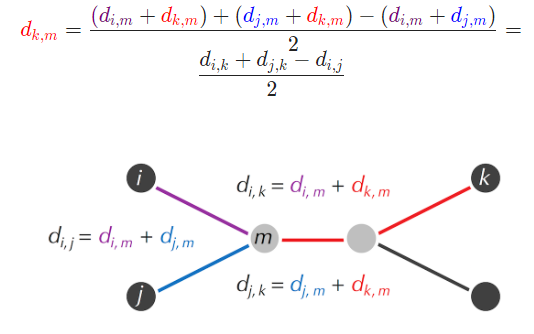

This discussion implies a recursive algorithm for the Distance-Based Phylogeny Problem:

find a pair of neighboring leaves i and j by selecting the minimum element Di,j in the distance matrix;
replace i and j with their parent, and recompute the distances from this parent to all other leaves as described above;
solve the Distance-Based Phylogeny problem for the smaller tree;
add the previously removed leaves i and j back to the tree.

To compute LimbLength(j) for a given leaf j, note that because Tree(D) is simple, we know that Parent(j) has degree at least 3 (unless Tree(D) has only two nodes). We can therefore think of Parent(j) as dividing the other nodes of Tree(D) into at least three subtrees, or smaller trees that would remain if we were to remove Parent(j) along with any edges connecting it to other nodes (see figure below). Because j is a leaf, it must belong to a subtree by itself; we call this subtree Tj. This brings us to the following result.

Limb Length Theorem: Given an additive matrix D and a leaf j, LimbLength(j) is equal to the minimum value of
(
D
i
,
j
+
D
j
,
k
−
D
i
,
k
)
/
2
(D
i,j
​
 +D
j,k
​
 −D
i,k
​
 )/2 over all leaves i and k.

In [33]:
def calculate_limb_length(N, j, M):
    min_limb_length = float('inf')  # Initialize with a very large number
    for i in range(N):
        for k in range(N):
            if i != j and k != j:
                # Compute the limb length using the formula
                limb_length = (M[i][j] + M[j][k] - M[i][k]) / 2
                if limb_length < min_limb_length:
                    min_limb_length = limb_length
    return int(min_limb_length)

def load_data_from_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # First line is the number of nodes, N
    N = int(lines[0].strip())

    # Second line is the index j of the leaf whose limb length we need to calculate
    j = int(lines[1].strip())

    # The rest are the distance matrix
    matrix = []
    for line in lines[2:]:
        row = list(map(int, line.split()))
        matrix.append(row)

    return N, j, matrix

In [34]:
# Distance matrix
distance_matrix = [
    [0, 13, 16, 10],  # i
    [13, 0, 21, 15],  # j
    [16, 21, 0, 18],  # k
    [10, 15, 18, 0]   # l
]

# Number of nodes
N = len(distance_matrix)

# Calculate limb length for node i (index 0)
node_index = 0  # Corresponding to node 'i'
limb_length_i = calculate_limb_length(N, node_index, distance_matrix)

# Print the result
print(f"Limb Length(i): {limb_length_i}")

Limb Length(i): 4


In [10]:
# File path to the input file
file_path = '/content/drive/MyDrive/Bioinformatics /BIO IV/dataset_30285_11.txt'  # Update with the correct path to your file

# Load data from the file
N, j, matrix = load_data_from_file(file_path)

# Calculate the limb length
limb_length = calculate_limb_length(N, j, matrix)

# Output the result
print(limb_length)

361


# **Algorithm for distance-based phylogeny reconstruction**



```
# AdditivePhylogeny(D)
    n ← number of rows in D
    if n = 2
        return the tree consisting of a single edge of length D1,2
    limbLength ← Limb(D, n)
    for j ← 1 to n - 1
        Dj,n ← Dj,n - limbLength
        Dn,j ← Dj,n
    (i, k) ← two leaves such that Di,k = Di,n + Dn,k
    x ← Di,n
    D ← D﻿ with row n and column n removed
    T ← AdditivePhylogeny(D)
    v ← the (potentially new) node in T at distance x from i on the path between i and k
    add leaf n back to T by creating a limb (v, n) of length limbLength
    return T
```



In [35]:
import numpy as np

def calculate_limb_length(distance_matrix: np.ndarray, target_node: int) -> int:

    min_length = np.inf
    other_nodes = [i for i in range(distance_matrix.shape[0]) if i != target_node]

    for current_node in range(distance_matrix.shape[0]):
        if current_node == target_node:
            continue
        limb_length = min(distance_matrix[other_nodes, target_node] - distance_matrix[other_nodes, current_node] + distance_matrix[target_node, current_node])
        min_length = min(min_length, limb_length)

    return min_length // 2

def find_node_indices(distance_matrix: np.ndarray) -> tuple[int, int]:
    """
    Find indices in the distance matrix that satisfy a specific condition.
    """
    for idx in range(distance_matrix.shape[0] - 1):
        difference = distance_matrix[idx] - distance_matrix[-1]
        matching_indices = np.where(difference == distance_matrix[idx, -1])
        if len(matching_indices[0]) > 0:
            return (matching_indices[0][0], idx)
    return None

def locate_closest_nodes(tree: dict, edge_weights: dict, target_distance: int, start: int, end: int) -> tuple[int, int, int, int]:

    paths = [[start]]
    visited = {start}
    path_to_target = []

    while paths:
        current_path = paths.pop()
        current_node = current_path[-1]
        visited.add(current_node)

        if current_node == end:
            path_to_target = current_path
            break

        for neighbor in tree[current_node]:
            if neighbor not in visited:
                paths.append(current_path + [neighbor])

    # Calculate the total distance along the path
    total_dist = 0
    for i in range(len(path_to_target) - 1):
        a, b = path_to_target[i], path_to_target[i + 1]
        if total_dist + edge_weights[(a, b)] > target_distance:
            return (a, b, target_distance - total_dist, total_dist + edge_weights[(a, b)] - target_distance)
        total_dist += edge_weights[(a, b)]

def construct_phylogenetic_tree(distance_matrix: np.ndarray, num_leaves: int, inner_node_counter: int) -> tuple[dict, dict, int]:

    if num_leaves == 2:
        tree = {0: [1], 1: [0]}
        weights = {(0, 1): distance_matrix[0, 1], (1, 0): distance_matrix[0, 1]}
        return tree, weights, inner_node_counter

    limb_length = calculate_limb_length(distance_matrix, num_leaves - 1)
    distance_matrix[:-1, -1] -= limb_length
    distance_matrix[-1, :-1] -= limb_length

    index_i, index_k = find_node_indices(distance_matrix)
    target_distance = distance_matrix[index_i, -1]

    tree, weights, inner_node_counter = construct_phylogenetic_tree(distance_matrix[:-1, :-1], num_leaves - 1, inner_node_counter)

    closest_i, closest_k, limb_i, limb_k = locate_closest_nodes(tree, weights, target_distance, index_i, index_k)
    new_node_index = closest_i

    # Check if a new inner node is needed
    if limb_i != 0:
        new_node_index = inner_node_counter
        inner_node_counter += 1
        tree[closest_i].remove(closest_k)
        tree[closest_k].remove(closest_i)

        tree[closest_i].append(new_node_index)
        tree[closest_k].append(new_node_index)
        tree[new_node_index] = [closest_i, closest_k]

        weights[(new_node_index, closest_i)] = limb_i
        weights[(closest_i, new_node_index)] = limb_i
        weights[(new_node_index, closest_k)] = limb_k
        weights[(closest_k, new_node_index)] = limb_k

        del weights[(closest_i, closest_k)]
        del weights[(closest_k, closest_i)]

    # Add the leaf node back to the tree
    tree[new_node_index].append(num_leaves - 1)
    tree[num_leaves - 1] = [new_node_index]
    weights[(num_leaves - 1, new_node_index)] = limb_length
    weights[(new_node_index, num_leaves - 1)] = limb_length

    return tree, weights, inner_node_counter

def print_phylogenetic_tree(tree: dict, weights: dict) -> None:

    for node in sorted(tree):
        for neighbor in sorted(tree[node]):
            print(f"{node}->{neighbor}:{weights[(node, neighbor)]}")

def read_distance_matrix(file_path: str) -> tuple[int, np.ndarray]:

    with open(file_path) as file:
        for index, line in enumerate(file):
            line = line.strip()
            if index == 0:
                size = int(line)
                matrix = np.zeros((size, size), dtype=np.int32)
            else:
                row_values = np.array(line.split()).astype(np.int32)
                matrix[index - 1] += row_values
    return size, matrix

# Execution
num_leaves, distance_matrix = read_distance_matrix("/content/drive/MyDrive/Bioinformatics /BIO IV/dataset_30286_6.txt")
phylo_tree, edge_weights, _ = construct_phylogenetic_tree(distance_matrix, num_leaves, num_leaves)
print_phylogenetic_tree(phylo_tree, edge_weights)


0->31:212
1->20:324
2->21:998
3->27:852
4->22:158
5->23:722
6->24:470
7->25:207
8->26:861
9->34:301
10->28:391
11->29:277
12->30:164
13->35:442
14->32:108
15->33:952
16->34:589
17->35:573
18->36:542
19->37:582
20->1:324
20->23:696
20->32:818
21->2:998
21->27:401
21->32:139
22->4:158
22->24:628
22->31:390
23->5:722
23->20:696
23->25:537
24->6:470
24->22:628
24->29:186
25->7:207
25->23:537
25->26:172
26->8:861
26->25:172
26->29:659
27->3:852
27->21:401
27->30:725
28->10:391
28->34:907
28->37:858
29->11:277
29->24:186
29->26:659
30->12:164
30->27:725
30->37:133
31->0:212
31->22:390
31->33:390
32->14:108
32->20:818
32->21:139
33->15:952
33->31:390
33->36:314
34->9:301
34->16:589
34->28:907
35->13:442
35->17:573
35->36:406
36->18:542
36->33:314
36->35:406
37->19:582
37->28:858
37->30:133
